In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import networkx as nx
from orinoco import (get_distance_along_river_using_fmm,
                     get_distance_segments,
                     get_undirected_river_network,
                     direct_river_network_using_distance,
                     export_edges_to_geodataframe,
                     export_nodes_to_geodataframe,
                     get_map_centroid_from_binary_mask,
                     apply_func_to_superpixels,
                     get_array_from_features,
                     get_width_features_from_segments,
                     add_width_features_to_graph,
                     add_flow_attributes,
                     get_width_geometries,
                     change_tuples_to_vector,
                     update_width_geometries
                     )
from skimage.color import label2rgb
import random
from shapely.geometry import Point
import geopandas as gpd
import scipy.ndimage as nd
from scipy.ndimage import find_objects


# Initialize Paths for Data And Output

In [2]:
map_name = 'stamen_terrain_12'  # options are `stamen_terrain_12` or `google_16`
data_path = Path(f'data/{map_name}')

In [3]:
product_dir = Path('products')
products_for_map_dir = product_dir/map_name
products_for_map_dir.exists()

True

# Read Data

In [4]:
with rasterio.open(products_for_map_dir/'water_mask.tif') as ds:
    water_mask = ds.read(1)
    transform = ds.transform
transform

Affine(25.0, 0.0, 640825.0,
       0.0, -25.0, 3285225.0)

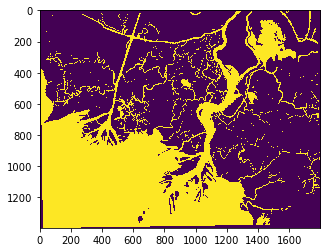

In [5]:
plt.imshow(water_mask)

In [6]:
with rasterio.open(products_for_map_dir/'ocean_mask.tif') as ds:
    ocean_mask = ds.read(1)
    profile = ds.profile

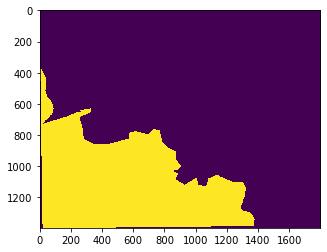

In [7]:
plt.imshow(ocean_mask)

We are going to get the resolution distance in the upper right corner (origin). Of course, this is not valid through the entire raster. The fast-marching method will use this `dx, dy` to approximate distance to our initialization mask (namely the ocean). We will update this distance at the end.

In [8]:
dx, dy = transform.a, -transform.e
dx, dy

(25.0, 25.0)

In [9]:
dist = get_distance_along_river_using_fmm(water_mask,
                                          ocean_mask,
                                          dx=dx,
                                          dy=dy,
                                          # removes areas with less than 2.5% of total size
                                          area_threshold=.025
                                          )

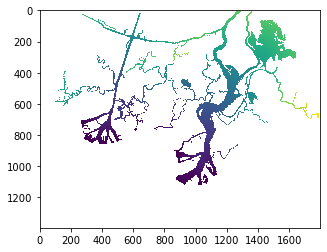

In [10]:
plt.imshow(dist)

We write the distance raster.

In [11]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(products_for_map_dir/'distance.tif', 'w', **p) as ds:
    ds.write(dist.astype(np.float32), 1)

We threshold the distance according to some number of pixels - below we use `pixel_step`.

In [12]:
pixel_step = 5

segments, interface_adj_segments = get_distance_segments(dist,
                                                         pixel_step,
                                                         dx=dx,
                                                         dy=dy)

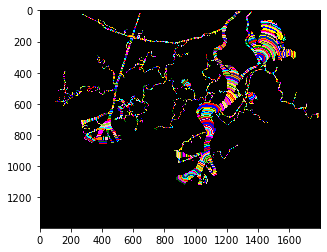

In [13]:
segments_rgb = label2rgb(segments, bg_label=0)
plt.imshow(segments_rgb)

In [14]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(products_for_map_dir/'segments.tif', 'w', **p) as ds:
    ds.write(segments.astype(np.int32), 1)

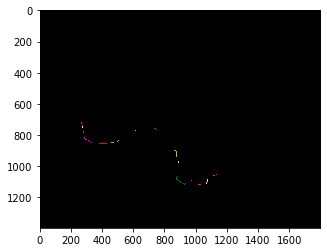

In [15]:
segment_interface_slice = np.isin(segments, interface_adj_segments)
segments_along_interface = segments.copy()
segments_along_interface[~segment_interface_slice] = 0

# To get same color scheme from above
ind = (segments_along_interface != 0)
interface_rgb = np.zeros(segments_rgb.shape)
interface_rgb[ind] = segments_rgb[ind]
plt.imshow(interface_rgb)

In [16]:
p = profile.copy()
p['dtype'] = 'int32'
with rasterio.open(products_for_map_dir/'segments_along_interface.tif', 'w', **p) as ds:
    ds.write(segments_along_interface.astype(np.int32), 1)

# Making an Undirected Network

In [17]:
rivG_undirected = get_undirected_river_network(segments, dist, profile, interface_adj_segments)

adding edges: 100%|██████████| 3034/3034 [00:00<00:00, 179911.76it/s]


In [18]:
type(rivG_undirected)

networkx.classes.graph.Graph

In [19]:
node_data =dict(rivG_undirected.nodes(data=True))
random.choice(list(node_data.items()))

((662625.0, 3271926.6666666665),
 {'label': 1616,
  'meters_to_interface': 15376.0634765625,
  'x': 662625.0,
  'y': 3271926.6666666665,
  'interface_adj': False})

In [20]:
edge_data =(rivG_undirected.edges(data=True))
edge_data = {(e[0], e[1]): e[2] for e in edge_data}
random.choice(list(edge_data.items()))

(((660883.8983050848, 3275030.9322033897),
  (661027.7777777778, 3274998.888888889)),
 {'length_m': 147.40446623693782, 'weight': 147.40446623693782})

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


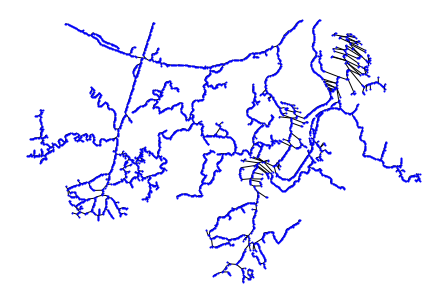

In [21]:
pos = {node: node for node in node_data.keys()}
nx.draw(rivG_undirected, 
        pos=pos, 
        node_size=1, 
        node_color='blue')
plt.show()

In [22]:
rivG = direct_river_network_using_distance(rivG_undirected, 
                                           remove_danlging_segments=True, 
                                           segment_threshold=3,
                                           meters_to_interface_filter_buffer=1_000,
                                          )

/Users/cmarshak/anaconda3/envs/centerlines/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


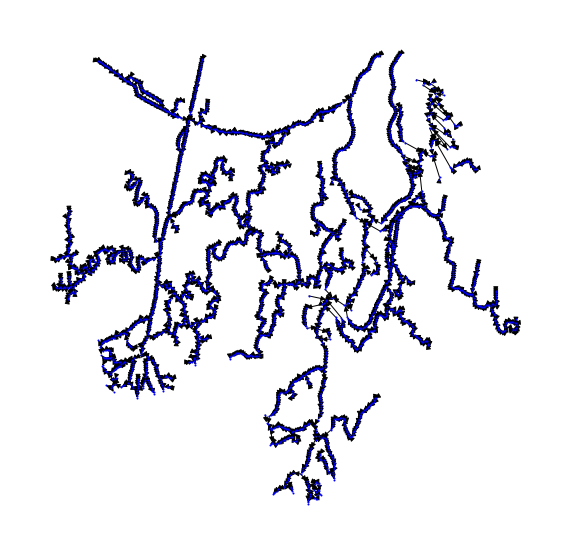

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
nx.draw(rivG, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

Once these are exported to `geojson` format below - we can view these including the arrows as indicated [here](https://gis.stackexchange.com/a/215842/114646).

In [24]:
str(profile['crs']).lower()

'epsg:32615'

In [25]:
df_edges = export_edges_to_geodataframe(rivG, profile)
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,geometry
0,402.421159,402.421159,0,1,0,LINESTRING (647602.103960396 3267089.108910891...
1,145.384062,145.384062,1,1,0,LINESTRING (647602.103960396 3267089.108910891...
2,603.030133,603.030133,2,1,0,LINESTRING (647602.103960396 3267089.108910891...
3,129.192136,129.192136,3,19,0,LINESTRING (649849.6062992126 3267797.83464566...
4,134.140428,134.140428,3,19,0,"LINESTRING (649723.347107438 3267825.20661157,..."


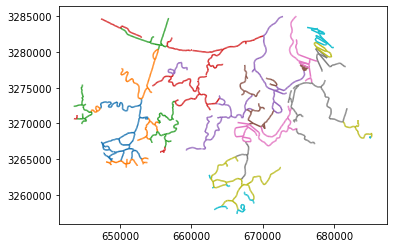

In [26]:
df_edges.plot(column='segment_id', categorical=True)

# Draw Interface Sink

We are going to add a node in the middle of the ocean that will can be visualized as a sink.

In [27]:
ocean_centroid = get_map_centroid_from_binary_mask(ocean_mask, profile)
ocean_centroid

(654489.7191008729, 3257678.169107866)

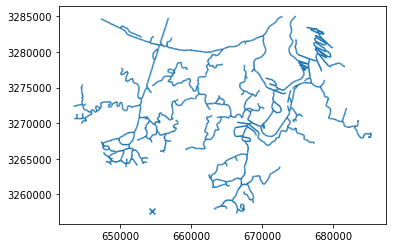

In [28]:
fig, ax = plt.subplots()
df_ocean_centroid = gpd.GeoDataFrame(geometry=[Point(ocean_centroid)],
                                     crs={'init':'epsg:4326'})
df_edges.plot(ax=ax)
df_ocean_centroid.plot(ax=ax, marker='x')

In [29]:
connected_to_interface = [node for node in rivG.nodes() if (rivG.nodes[node]['interface_adj'])]
rivG_sink = rivG.copy()

edge_data_to_interface = {(node, ocean_centroid): {'weight': 0,
                                                   'meters_to_interface': 0} for node in connected_to_interface}

rivG_sink.add_edges_from(edge_data_to_interface.keys())

nx.set_edge_attributes(rivG_sink, edge_data_to_interface)

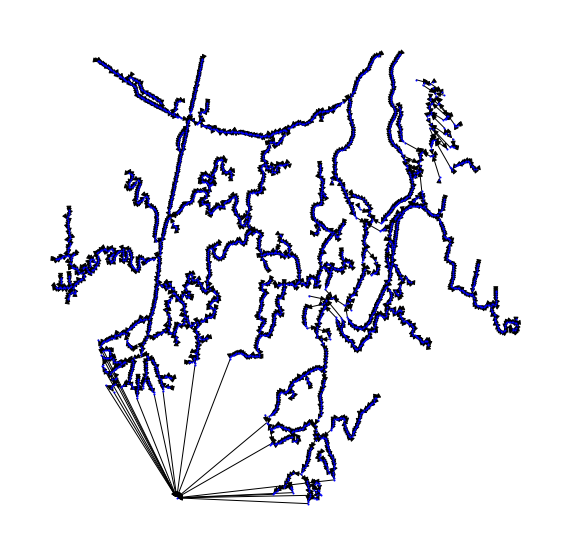

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
pos[ocean_centroid] = ocean_centroid

nx.draw(rivG_sink, 
        pos=pos, 
        node_size=1,
        arrows=True,
        arrowsize=10,
        ax=ax,
        node_color='blue')
plt.show()

# Including Widths

Unfortunately, this is the messiest part of the process. At some point, we will streamline this, but as we will have to update it going forward, some things are a bit more exposed.

There are two ways to proceed.

1. Using the pixelwise distance as in [RivGraph](https://github.com/jonschwenk/RivGraph)
2. Usiing the geometric approach as in [RivWidth](http://uncglobalhydrology.org/rivwidth/) or this code [base](https://github.com/geoallen/streamWidthAnalysis2017).

Our approach is to adapt 2. and fill in gaps with an adaptation of 1.

Our approach is as follows. For each node, we estimate a flow direction determined by network structure. Specifically, we consider all edge vectors connected to a node $i$ oriented so that they are within the 1st quadrant (this can be done reversing vectors that have angle $\geq \pi/2$) and then taking a weighted average according to the inverse square distance (those closer to the node are likely to be more indicative of its current distance), that is the flow $\vec f_i$ at node is is:

$$
\vec f_i = \sum_{\vec x : x = (i, j)} \frac 1{||x||^2} \cdot  \frac{\vec x}{||x||}
$$

Again, where $|| \cdot ||$ is the normal $L_2$ norma and $x$ is possibly reversed to ensure all edges connected to $i$ are within $\pi/2$ of each other. With the flows obtained, we then consider the perpendicular line to these and intersect with the water geometry using python APIs. 

This is currently not optimized for speed and we strongly believe there are ways to speedup this code even with existing python modules and APIs. However, the current process produces decent products and such investigations will have to be put temporarily on hold.

There are several challenges with this approach. One issue with is that certain centroids are outside the river geometry and therefore the basic approach is invalid. We simply replace such empty geometries using the approach from (1) above. There are other ways we could proceed, but given that this is a first pass, we hope this will provide some insight.

### Obtaining width features

This is just using normal scipy functionality and segmentation to determine the approximate width within as egment.

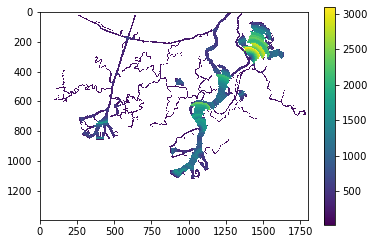

In [31]:
width_features = get_width_features_from_segments(segments, profile)
widths = get_array_from_features(segments, width_features)
plt.imshow(widths)
plt.colorbar()

In [32]:
rivG = add_width_features_to_graph(rivG, width_features.ravel(), width_label='segment_width')

In [33]:
p = profile.copy()
p['dtype'] = 'float32'
with rasterio.open(products_for_map_dir/'features_widths.tif', 'w', **p) as ds:
    ds.write(widths.astype(np.float32), 1)

# Obtaining Width Geometries

First, we add flow attributes as dictated above.

In [34]:
rivG = add_flow_attributes(rivG)

flow vector computation: 100%|██████████| 2735/2735 [00:00<00:00, 9115.76it/s]


Observe the new attributes in the node data:

In [35]:
node_data =dict(rivG.nodes(data=True))
random.choice(list(node_data.items()))

((652556.25, 3267643.75),
 {'label': 2456,
  'meters_to_interface': 8123.105380829612,
  'x': 652556.25,
  'y': 3267643.75,
  'interface_adj': False,
  'graph_degree': 2,
  'cc_id': 0,
  'segment_width': 125.0,
  'flow_vector': (-0.9494446753859267, -0.2644257501075986),
  'flow_vector_perp': (0.2644257501075986, -0.9494446753859267)})

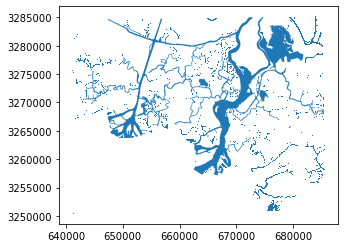

In [36]:
water_mask_df = gpd.read_file(products_for_map_dir/'river_geometry')
water_mask_df.plot()

This is the expensive computation regarding intersections. We use multithreading, but we suspect there are ways to improve this.

In [37]:
node_to_width_geo_dict = get_width_geometries(rivG, water_mask_df, profile, multithreaded=True)

100%|██████████| 2735/2735 [02:02<00:00, 22.24it/s]


Let's save the geometry to a file

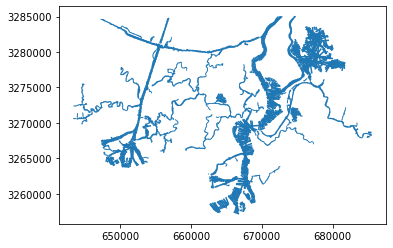

In [38]:
nodes, geometry = zip(*node_to_width_geo_dict.items())
node_x, node_y = zip(*nodes)
df_width_geometries = gpd.GeoDataFrame({'node_x': node_x, 'node_y': node_y},
                                       geometry=list(node_to_width_geo_dict.values()),
                                       crs=water_mask_df.crs)
df_width_geometries.plot()

In [39]:
df_width_geometries.head()

,node_x,node_y,geometry
0,647602.103960,3.267089e+06,"LINESTRING (647375 3267222.737575603, 647925 3..."
1,647368.333333,3.267417e+06,"LINESTRING (647625.2187084554 3267600, 647325 ..."
2,647500.787402,3.266985e+06,"LINESTRING (647425 3267058.485796687, 647742.4..."
3,647651.153846,3.266488e+06,"LINESTRING (647600 3266436.129865081, 648007.5..."
4,649849.606299,3.267798e+06,"LINESTRING (649777.7328862546 3268100, 649875 ..."


In [40]:
df_width_geometries.geometry[0].coords[0]

(647375.0, 3267222.737575603)

In [41]:
df_width_geometries.to_file(products_for_map_dir/'width_geometries.geojson', driver='GeoJSON')

Updating the network (exposed).

In [42]:
segment_width_dict = nx.get_node_attributes(rivG, 'segment_width')
random.choice(list(segment_width_dict.items()))

((662942.6470588235, 3271118.382352941), 116.42135623730951)

In [43]:
rivG = update_width_geometries(rivG, node_to_width_geo_dict)

In [44]:
node_data =dict(rivG.nodes(data=True))
random.choice(list(node_data.items()))

((650386.3333333334, 3268211.0),
 {'label': 2318,
  'meters_to_interface': 3322.181112493482,
  'x': 650386.3333333334,
  'y': 3268211.0,
  'interface_adj': False,
  'graph_degree': 2,
  'cc_id': 0,
  'segment_width': 328.5533905932738,
  'flow_vector': (0.8337897869854063, 0.54739773630714),
  'flow_vector_perp': (-0.54739773630714, 0.8337897869854063),
  'width_m': 358.8751757059658,
  'width_m_from_geometry': 358.8751757059658,
  'width_geo_0': (650295.0773758554, 3268350.0),
  'width_geo_1': (650492.0326797647, 3268050.0)})

# Save Network

First, we export each of the graphs to Geopandas `GeoDataFrame`.

In [45]:
df_nodes = export_nodes_to_geodataframe(rivG, profile)
df_nodes = change_tuples_to_vector(df_nodes)
df_edges = export_edges_to_geodataframe(rivG, profile)

For example, the edge attributes are now columns in a dataframe.

In [46]:
df_edges.head()

,length_m,weight,segment_id,edges_in_segment,cc_id,geometry
0,402.421159,402.421159,0,1,0,LINESTRING (647602.103960396 3267089.108910891...
1,145.384062,145.384062,1,1,0,LINESTRING (647602.103960396 3267089.108910891...
2,603.030133,603.030133,2,1,0,LINESTRING (647602.103960396 3267089.108910891...
3,129.192136,129.192136,3,19,0,LINESTRING (649849.6062992126 3267797.83464566...
4,134.140428,134.140428,3,19,0,"LINESTRING (649723.347107438 3267825.20661157,..."


We save these using the geopandas ecosystem. We used `geojson` because some of our column names are long and shapefiles have a 10 character limit. However, removing the `driver` keyword (the shapefile is default), saves the above dataframe to an ESRI Shapfile.

In [47]:
df_nodes.head()

,label,meters_to_interface,x,y,interface_adj,graph_degree,cc_id,segment_width,width_m,width_m_from_geometry,flow_vector_x,flow_vector_y,flow_vector_perp_x,flow_vector_perp_y,width_geo_0_x,width_geo_0_y,width_geo_1_x,width_geo_1_y,geometry
0,2479,145.384062,647602.103960,3.267089e+06,False,5,0,467.442890,638.146529,638.146529,0.464720,0.789799,-0.789799,0.464720,647375.000000,3.267223e+06,647925.000000,3.266899e+06,POINT (647602.103960396 3267089.108910891)
1,2484,0.000000,647368.333333,3.267417e+06,True,1,0,225.000000,368.833766,368.833766,0.580910,-0.813968,0.813968,0.580910,647625.218708,3.267600e+06,647325.000000,3.267386e+06,POINT (647368.3333333334 3267416.666666667)
2,2514,0.000000,647500.787402,3.266985e+06,True,1,0,229.950976,442.661285,442.661285,0.696889,0.717179,-0.717179,0.696889,647425.000000,3.267058e+06,647742.467363,3.266750e+06,POINT (647500.7874015748 3266984.842519685)
3,2563,0.000000,647651.153846,3.266488e+06,True,2,0,133.113883,580.849287,580.849287,-0.696304,0.685672,-0.685672,-0.696304,647600.000000,3.266436e+06,648007.550495,3.266850e+06,POINT (647651.1538461539 3266488.076923077)
4,2378,2625.821578,649849.606299,3.267798e+06,False,3,0,422.213595,420.332722,420.332722,0.759922,0.180756,-0.180756,0.759922,649777.732886,3.268100e+06,649875.000000,3.267691e+06,POINT (649849.6062992126 3267797.834645669)


In [48]:
df_edges.to_file(products_for_map_dir/'orinoco_edges.geojson', driver='GeoJSON')
df_nodes.to_file(products_for_map_dir/'orinoco_nodes.geojson', driver='GeoJSON')
nx.write_gpickle(rivG, products_for_map_dir/'river_network.pkl')

And if you wish to check the direction of flow in QGIS, use this [feature](https://gis.stackexchange.com/a/215842/114646). 